# Load packages

In [1]:
# the Gym environment class
from src.gym2048 import gym2048
from src.models import CNN22
from src.RL import TDL

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# used for clearing the display in jupyter notebooks

import pickle

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Load and test environment

In [2]:
env = gym2048()

In [4]:
env.check()


 Check SwipeLeft 

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True

 Check SwipeLeft 

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

 Check encode 

# TD-learning

In [7]:
#env = Monitor(env, filename="./logs/tdl_cnn_2024_11_14_1.csv")
model = TDL(CNN22, env, device="mps")
#model.load_network('./TDL_CNN_2024_11_10_1/rl_model_10000_epsiodes.zip')

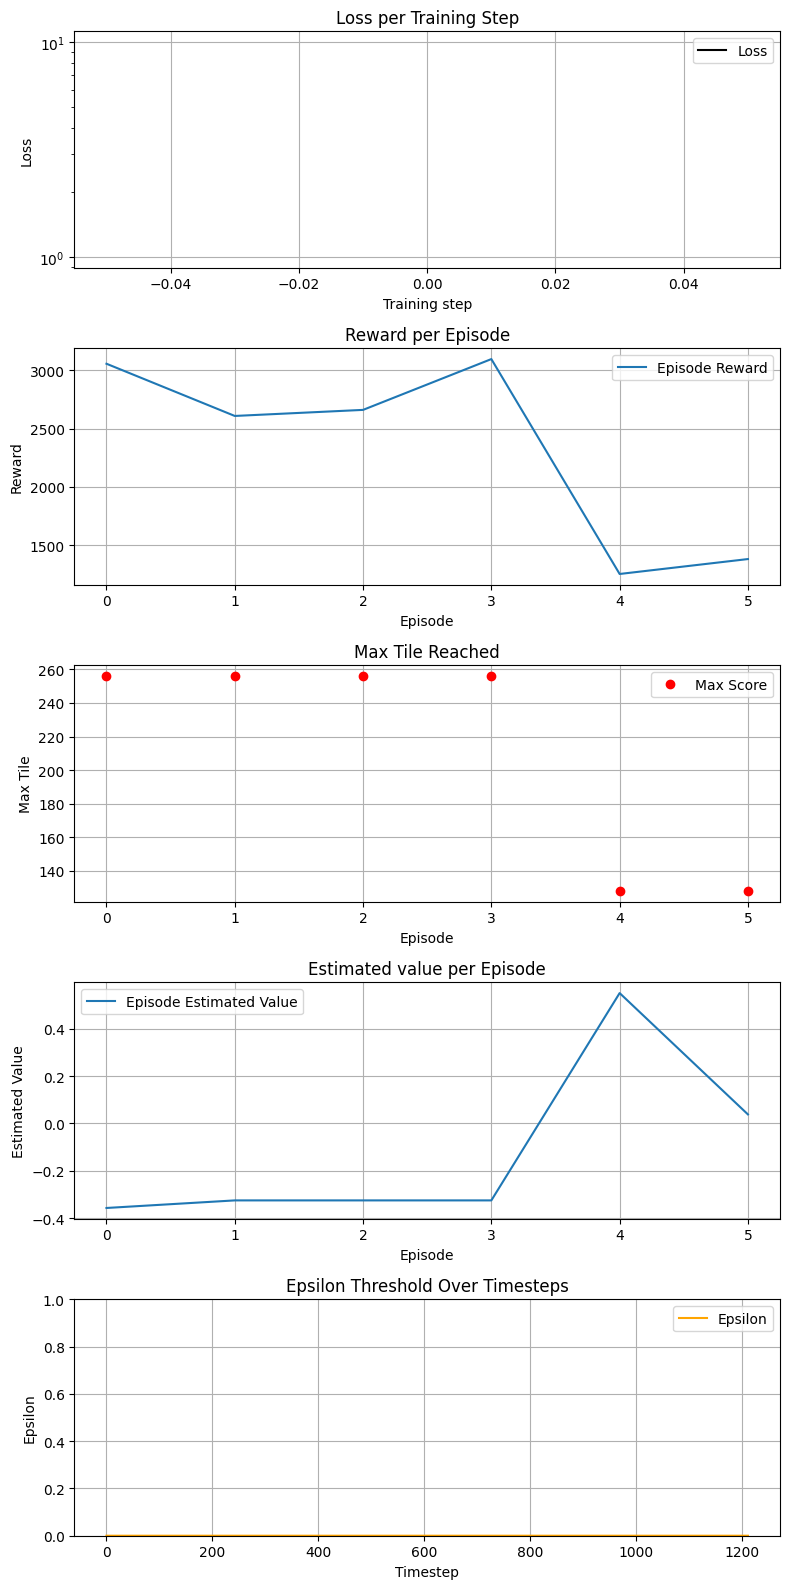

KeyboardInterrupt: 

In [8]:
#profiler = cProfile.Profile()
#profiler.enable()

model.learn(
    1e7, 
    lr=1e-3,
    gamma=0.99,
    train_freq=1024,
    eps_start=0.0, 
    eps_end=0.0, 
    exploration_fraction=0.05,
    target_network_update_freq=-1, # set to -1 to not use target network
    save_path='./TDL_CNN_2024_11_15/', 
    save_freq=2500,
    check_gradient_freq=10,
    jump=False,
    symmetry=False,
    batch_size=1024, 
    buffer_size=1024, 
    prioritized_replay=False, 
    reprioritize_freq=300
    )

#profiler.disable()
#stats = pstats.Stats(profiler)

In [ ]:
#stats.dump_stats('./profile_results.prof')

In [ ]:
#network = CNN22_TDL
#env = gym2048.gym2048()
#model = TDL(network, env, batch_size=1024, buffer_size=1024, prioritized_replay=False, reprioritize_freq=300)
#model.load_network('./TDL_CNN_2024_11_13_1/rl_model_5000_epsiodes.zip')

model.eval()

print_intermediate = False

max_tile = 0

terminated = False

state, info = model.env.reset()

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, value = model.predict(state, verbose=False)
  next_afterstate, reward = model.env.afterstate(state, action)
  state, reward, terminated, _, _ = model.env.step(action)
  cum_reward += reward

  #print(['left','right','up','down'][action])
  #print(model.env.unwrapped.decode(state))
  #print(reward)
  #print(value)

print(model.env.unwrapped.decode(state))
print(cum_reward)
print(cpt)

In [ ]:
def get_param_stats(model):
    stats = {
        "Layer": [],
        "Min": [],
        "Max": [],
        "Mean": [],
        "Std": [],
        "Num Params": []
    }

    for name, param in model.named_parameters():
        if param.requires_grad:
            stats["Layer"].append(name)
            stats["Min"].append(param.data.min().item())
            stats["Max"].append(param.data.max().item())
            stats["Mean"].append(param.data.mean().item())
            stats["Std"].append(param.data.std().item())
            stats["Num Params"].append(param.numel())

    # Convert to DataFrame for easy viewing
    stats_df = pd.DataFrame(stats)
    return stats_df

# Example usage
model_stats = get_param_stats(model.policy_network)
print(model_stats)

In [ ]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./2048_tdl_cnn_2024_11_13_7500.pkl', 'wb') as file:
    pickle.dump(data, file)

# Comparison

In [ ]:
models = {
    'Random': './2048_random.pkl',
    'PPO': './2048_ppo.pkl',
    'DQN': './2048_dqn_165k.pkl',
    'TDL_nov1': './2048_tdl_3500.pkl',
    'TDL_nov9': './2048_tdl_cnn_2024_11_09_2500.pkl',
    'TDL_nov13': './2048_tdl_cnn_2024_11_13_7500.pkl'
}

df = pd.DataFrame()

for id, path in models.items():
    with open(path, 'rb') as file:
        data = pickle.load(file)
    df_loc = pd.DataFrame({'max_tiles':data['max_tiles']})
    df_loc['model'] = id
    df = pd.concat([df, df_loc], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()